In [19]:
model = TransformerModel(
    n_dims=24,
    n_positions=101,
    n_embd=256,
    n_layer=12,
    n_head=8,
    pred_type="regression",
).cuda()

number of parameters: 9.48M


In [24]:
task_sampler = get_task_sampler(
    task_name="linear_regression",
    batch_size=2,
    n_points=47,
    n_dims=24,
    n_dims_truncated=1,
    device="cuda",
)

real_task = task_sampler()
xs, ys = real_task.xs.float(), real_task.ys.float()
n_loops = 1; horizon_start = max(0, n_loops - 20)
#xs, ys, xs.shape, ys.shape

In [25]:
y_pred = model(xs, ys, add_inputs_embeds=False) 
print(y_pred)
loss = (ys - y_pred).square().mean()
loss

tensor([[ 1.1899,  0.2882,  1.3921, -0.4105,  1.5441,  0.0842,  0.2014,  0.8957,
          0.1141,  1.3465,  1.3814,  1.5093,  0.7330, -0.0093,  0.2738,  0.6822,
          1.2707,  1.1074,  1.0221,  1.2728,  1.2855,  1.2002,  1.1829,  1.0612,
          1.1805,  0.3084,  1.3286,  1.3020,  0.8203,  1.2340,  0.0782, -0.3885,
          1.2260,  0.9377,  0.5229,  0.3381,  0.0377,  1.4034,  0.9860, -0.4787,
         -0.5612, -0.0361, -0.6507, -0.3089,  1.3391,  1.5476,  0.0523],
        [-0.0694,  0.9763,  1.4545,  0.3020,  0.0100,  1.1447,  1.1948,  1.3504,
          0.5366,  0.9851,  1.4244,  1.3905,  0.9890,  1.4787, -0.0476,  1.0664,
         -0.4766,  1.2083,  0.3426,  1.2229,  1.3630,  0.0975,  1.2856,  1.2211,
          1.3766,  0.8072,  0.1718,  0.0177,  0.9401,  0.7728,  0.5909,  0.2804,
         -0.5162,  0.7345,  0.8306,  0.5420, -0.5447,  1.4368,  1.1203, -0.0127,
          0.4002,  1.4595,  0.6552,  0.6681, -0.2934,  1.5469,  1.3722]],
       device='cuda:0', grad_fn=<SelectBack

tensor(0.8776, device='cuda:0', grad_fn=<MeanBackward0>)

In [5]:
# from IPython import display
# 
# class GraphPlotter:
#     def __init__(self, val_step):
#         self.fig = plt.figure(figsize = (10,4))
#         self.ax = self.fig.subplots(1, 3)
#         self.val_step = val_step
#         
#     def plot_graph(self, metrics):
#         steps = [t_loss["step"] for t_loss in metrics]
#         self.ax[0].plot(steps, [t_loss["overall_loss"] for t_loss in metrics])
#         self.ax[0].legend(['Train'])
# 
#         self.ax[1].plot(steps, [list(t_loss["pointwise/loss"].values())[-1] for t_loss in metrics])
#         self.ax[1].legend(['pointwise_loss_mean'])
# 
#         self.ax[2].plot(steps, [t_loss["scaled_loss"] for t_loss in metrics])
#         self.ax[2].legend(['scaled_loss'])
# 
#         plt.show()
#     
#     
# def train_step(n_loops, model, xs, ys, optimizer, ctx, scaler, n_loop_window, family = 'gpt2'):
#     """n_loop_window: T"""
#     if family == 'gpt2':
#         with ctx:
#             #y_pred = model(xs, ys, add_inputs_embeds=args.training.add_inputs_embeds)  # [B, n]
#             y_pred = model(xs, ys, add_inputs_embeds=False)  # [B, n]
#             # list of [B, n], length K + 1, get rid of the 0-th one
#             loss = (ys - y_pred).square().mean()  # auto on both K and n (number of in context samples)
#             
#     elif family == 'gpt2_loop':
#         with ctx:
#             horizon_start = max(0, n_loops - n_loop_window)
#             y_pred_list = model(xs, ys, horizon_start, n_loops)
#             # list of [B, n], length K
#             y_pred_arr = torch.cat(y_pred_list, dim=0)  # [B * K, n]
#             y_star_arr = torch.cat([ys] * len(y_pred_list), dim=0)  # [B * K, n]
#             loss = (y_star_arr - y_pred_arr).square().mean()  # auto on both K and n (number of in context samples)
#             y_pred = y_pred_list[-1]  # [B, n]
#  
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()
# 
#     optimizer.zero_grad(set_to_none=True)
#     return loss.detach(), y_pred.detach()
# 
# 
# def train_loop(model,
#                lr=0.0001, 
#                task_name = "linear_regression", 
#                batch_size=64,
#                n_loop_window = 20,
#                model_n_dims=MODEL_N_DIMS,
#                train_steps = STEPS,
#                family = "gpt2",
#                val_size = 1000,
#                experiment_name = "linear_regression_gpt_2",
#                out_dir = "./results2/linear_regression_baseline",
#                do_wandb_log = False,
#                n_loops = 1,
#                n_points = 21,
#                log_every_steps = LOG_EVERY_STEPS):
#     
#     graph_plotter = GraphPlotter(log_every_steps)
#     
#     state_path = "state.pt"
#     # TORCH 2.0 ZONE ###############################
#     torch.set_float32_matmul_precision('highest')
#     torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
#     torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
#     dtype = 'float16'  # 'bfloat16', 'float32'
#     ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
#     ctx = torch.amp.autocast(device_type='cuda', dtype=ptdtype, cache_enabled=False)
# 
#     
#     if do_wandb_log:
#         wandb.init(
#             dir="results",
#             project="looped_transformers",
#             #config=args.__dict__,
#             notes="args.wandb.notes",
#             name=experiment_name,
#             mode="disabled",
#             resume=True,
#         )
# 
#     torch.manual_seed(SEED)
#     # model = torch.compile(model)
# 
#     model.to(DEVICE)
#     model.train()
# 
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
#     scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))
#     
#     metrics = []
# 
#     pbar = tqdm(range(0, train_steps))
#     for i in pbar:
# 
#         task_sampler = get_task_sampler(
#             task_name=task_name,
#             batch_size=batch_size,
#             n_points=n_points, #curriculum.n_points,
#             n_dims= model_n_dims,
#             n_dims_truncated= model_n_dims, #curriculum.n_dims_truncated,
#             device=DEVICE,
#             sparsity=False,
#         )
# 
#         real_task = task_sampler()
#         xs, ys = real_task.xs.float(), real_task.ys.float()
#         loss, output = train_step(n_loops, model, xs, ys, optimizer, ctx, scaler, n_loop_window, family=family)
#         train_loss = loss
#         train_losses.append(loss.item())
#         
#         # EVALUATION ======================================
#         point_wise_tags = list(range(n_points))  #list(range(curriculum.n_points))  # [0, 1, 2, ..., n-1]
#         if i % log_every_steps == 0:
#             point_wise_loss = (output - ys).square().mean(dim=0)  # [n,]
#             pointwise_losses.append(point_wise_loss[-1].item())
#  
#             metrics.append(
#                 {
#                 "scaled_loss": loss.item() / model_n_dims,
#                 "overall_loss": train_loss.item(),
#                 "loop_times": n_loops,
#                 "pointwise/loss": dict(
#                     zip(point_wise_tags, point_wise_loss.detach().cpu().numpy())
#                 ),
#                 "n_points": n_points,
#                 "n_dims": model_n_dims,
#                 "lr": optimizer.param_groups[0]['lr'],
#                 "step": i,
#             })
#             
#             if do_wandb_log:
#                 wandb.log(
#                     {
#                         "scaled_loss": loss / curriculum.n_dims_truncated,
#                         "overall_loss": train_loss,
#                         "loop_times": curriculum.n_loops,
#                         "pointwise/loss": dict(
#                             zip(point_wise_tags, point_wise_loss.detach().cpu().numpy())
#                         ),
#                         "n_points": curriculum.n_points,
#                         "n_dims": curriculum.n_dims_truncated,
#                         "lr": optimizer.param_groups[0]['lr'],
#                     },
#                     step=i,
#                 )
# 
#         #curriculum.update()
# 
#         pbar.set_description(f"train_loss: {train_loss}")
#         if i % SAVE_EVERY_STEPS == 0:
#             training_state = {
#                 "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "train_step": i,
#                 "val_loss": loss,
#                 "train_loss": train_loss,
#             }
#             torch.save(training_state, state_path)
#         # if (KEEP_EVERY_STEPS > 0
#         #         and i % KEEP_EVERY_STEPS == 0
#         #         and i > 0 ) or (i == STEPS - 1):
#         #     torch.save({'model': model.state_dict()},
#         #                os.path.join(out_dir, f"model_{i}.pt"))
#             
#     graph_plotter.plot_graph(metrics)
#     return metrics

# 
# def validate_model(model, n_loops, model_n_dims, n_points,val_size = 1000, batch_size = 64, task_name = "linear_regression", family="gpt_2"):
#     task_sampler = get_task_sampler(
#         task_name=task_name,
#         batch_size=batch_size,
#         n_points=n_points, #curriculum.n_points,
#         n_dims= model_n_dims,
#         n_dims_truncated= model_n_dims, #curriculum.n_dims_truncated,
#         device=DEVICE,
#         sparsity=False,
#     )
# 
#     val_loader = gen_dataloader(task_sampler, val_size, batch_size)
#     
#     val_loss = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             xs, ys = batch['x'].to(DEVICE), batch['y'].to(DEVICE)
#             if family == 'gpt2':
#                 output = model(xs, ys)  # [B,]
#             elif family == 'gpt2_loop':
#                 n_loops = n_loops # curriculum.n_loops  # K
#                 y_pred_list = model(xs, ys, 0, n_loops)
#                 output = y_pred_list[-1]  # [B, n]
#             else:
#                 raise NotImplementedError
#             point_wise_loss = (output - ys).square().mean(dim=0)
#             loss = point_wise_loss[-1] / model_n_dims
#             val_loss += loss.item()
#     val_loss /= len(val_loader)
#     return val_loss

In [ ]:
###Consts
STEPS = 100_000
SEED = 42
DEVICE = 'cuda'
MODEL_N_DIMS = 10
LOG_EVERY_STEPS = 1000
SAVE_EVERY_STEPS = 1000
KEEP_EVERY_STEPS = 1000

### Import libraries and scripts
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import wandb

import matplotlib.pyplot as plt
import numpy as np

import os
from tqdm import tqdm

from tasks import get_task_sampler
from models import TransformerModel, TransformerModelLooped
from main_utils import gen_dataloader
from curriculum import CurriculumSimple

number of parameters: 0.79M


  0%|          | 0/5000 [00:00<?, ?it/s]

0


train_loss: 1.7762774229049683: 100%|██████████| 5000/5000 [03:04<00:00, 27.15it/s]


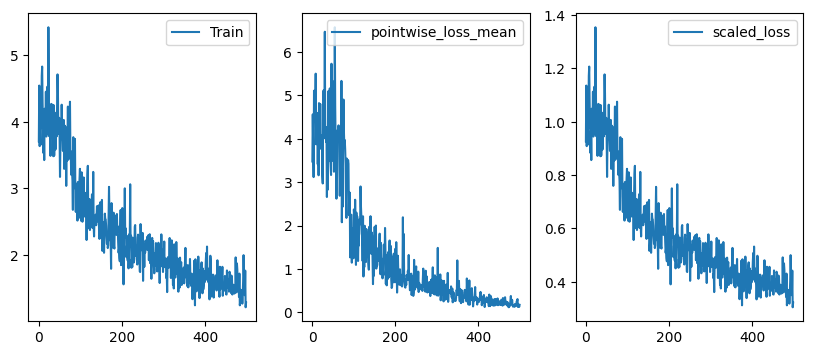

In [40]:
model = TransformerModelLooped(
    n_dims=4,
    n_positions=101,
    n_embd=256,
    n_layer=1,
    n_head=4,
    pred_type="regression",
).cuda()

metrics_1 = train_loop(model, n_loops=5, model_n_dims=4, log_every_steps=10, train_steps=5000, family="gpt2_loop")

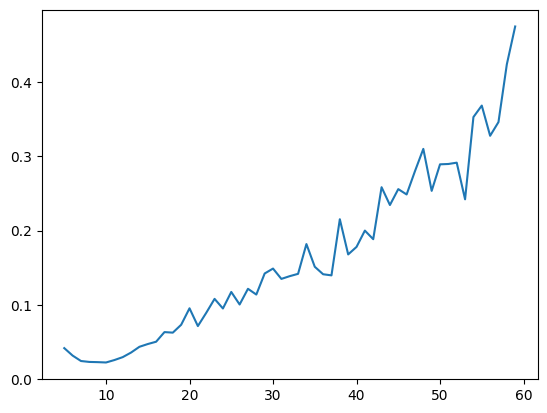

In [54]:
val_by_loop = []
loop_steps = []
for i in range(5, 60):
    val_loss = validate_model(model, n_loops=i, model_n_dims=4, n_points=21, family="gpt2_loop")
    val_by_loop.append(val_loss)
    loop_steps.append(i)

plt.plot(loop_steps, val_by_loop)

In [56]:
task_sampler = get_task_sampler(
    task_name="linear_regression",
    batch_size=2,
    n_points=5,
    n_dims=4,
    n_dims_truncated=4,
    device="cuda",
)

real_task = task_sampler()
xs, ys = real_task.xs.float(), real_task.ys.float()
n_loops = 1; horizon_start = max(0, n_loops - 20)
#xs, ys, xs.shape, ys.shape

In [57]:
from models import TransformerModelLoopedLastNTokens
model = TransformerModelLoopedLastNTokens(3, n_dims=4, n_positions=101, n_embd=256, n_layer=1, n_head=4, pred_type="regression").to(DEVICE)


ImportError: cannot import name 'TransformerModelLoopedLastNTokens' from 'models' (C:\Users\Vadim_K\DataspellProjects\looped_transformer\scripts\models.py)

In [58]:
metrics_1

[{'scaled_loss': 0.9268081188201904,
  'overall_loss': 3.7072324752807617,
  'loop_times': 5,
  'pointwise/loss': {0: 3.0326443,
   1: 2.856001,
   2: 2.7527213,
   3: 3.8682554,
   4: 3.7632809,
   5: 4.7098584,
   6: 2.9249206,
   7: 3.8348951,
   8: 2.9692202,
   9: 4.1612377,
   10: 3.7514799,
   11: 3.4068003,
   12: 4.6305294,
   13: 2.4467754,
   14: 4.503695,
   15: 4.0356092,
   16: 4.4414744,
   17: 4.92326,
   18: 3.4029028,
   19: 4.069835,
   20: 3.476421},
  'n_points': 21,
  'n_dims': 4,
  'lr': 0.0001},
 {'scaled_loss': 1.13578462600708,
  'overall_loss': 4.54313850402832,
  'loop_times': 5,
  'pointwise/loss': {0: 3.9410648,
   1: 5.2439685,
   2: 3.472449,
   3: 3.948338,
   4: 5.0783877,
   5: 5.273327,
   6: 2.8457298,
   7: 5.3942556,
   8: 4.3741145,
   9: 3.937879,
   10: 3.6726127,
   11: 6.133465,
   12: 3.2386818,
   13: 6.2646613,
   14: 3.0926995,
   15: 5.4573236,
   16: 5.0985956,
   17: 5.253108,
   18: 4.9397454,
   19: 4.1673765,
   20: 4.5615873},
  'n